In [72]:
! pip install beautifulsoup4
! pip install pandas
! pip install opencv-python
! pip install matplotlib
! pip install requests
! pip install selenium

In [2]:
#import bibliotek
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import numpy as np
import cv2
import math
import matplotlib

from os import path

In [ ]:
#url do strony ze wszystkimi igzyskami
url = 'http://www.olympedia.org/editions'

In [ ]:
req = requests.get(url).content
soup = BeautifulSoup(req)

In [ ]:
#id igrzysk po 1995 
edycja = []
for i in range(1, 33):   #33 - bo tyle bylo igrzysk letnich
    igrzyska = str(soup.find('table', class_ = "table table-striped").find_all('tr')[i].find_all('td')[1].find_all('a')[0]).split('editions/')[1]
    rok = int(igrzyska.split('>')[1][:4])
    #if rok > 1995:
    edycja.append([rok, igrzyska.split('"')[0]])

In [ ]:
edycja

In [ ]:
#url igrzysk po 1995, proba dla wszystkich
url_athletics = []
for i in range(len(edycja)):
    url_athletics.append(url + '/' + edycja[i][1] + '/sports/ATH')

In [ ]:
soup_athletics = []
for i in range(len(url_athletics)):
    req_athletics = requests.get(url_athletics[i]).content
    soup_athletics.append(BeautifulSoup(req_athletics))

In [ ]:

soup_athletics.csv

In [ ]:
#kody (id) dla konkurencji sprinterskich mezczyzn na igrzyskach
kod = []
#na io 2020 '4 × 100 metres Relay, Men' byl jakis inny x, dlatego jest 2x
konkurencje = ['100 metres, Men', '200 metres, Men', '4 x 100 metres Relay, Men', '110 metres Hurdles, Men', '4 × 100 metres Relay, Men'] #'100 metres, Women', '200 metres, Women', '4 x 100 metres Relay, Women']
konkurencje=['100 metres, Men']
for i in range(len(soup_athletics)):
    klas = soup_athletics[i].find('table', class_ = "table table-striped") #dla io np w 1916 i 1940 mamy puste, bo ich nie bylo
    if klas is not None:          #sprawdzamy poprzez is not None, aby opuscic puste io
        ile = soup_athletics[i].find('table', class_ = "table table-striped").find_all('tr')
        for j in range(1, len(ile)-1):
            dane = str(ile[j].find_all('a'))
            kon = dane.split('>')[1].split('<')[0]
            for k in konkurencje:
                if kon == k:
                    kod.append([edycja[i][0], kon, dane.split('results/')[1].split('"')[0]])

In [ ]:
kod

In [ ]:
#url dla konkurencji sprinterskich
url_konkurencja = []
for i in range(len(kod)):
    url_konkurencja.append('http://www.olympedia.org/results/'+kod[i][2])

In [ ]:
soup_konkurencja = []
for i in range(len(url_konkurencja)):
    req_konkurencja = requests.get(url_konkurencja[i]).content
    soup_konkurencja.append(BeautifulSoup(req_konkurencja))

In [ ]:
#wszyscy niepowtarzalni zawodnicy bioracy udzial w konkurencjach sprinterskich 1995 - 2021
zawodnik = []

for j in range(len(soup_konkurencja)):
    p = soup_konkurencja[j].find('table', class_ = "table table-striped").find_all('a')
    for i in range(len(p)):
        typ = str(p[i]).split("/")[1]
        if typ == 'athletes':
            r = str(p[i]).split('/')[2]
            nr = r.split('"')[0]
            #zaw = r.split('>')[1][:-1]
            if nr not in zawodnik:
                zawodnik.append(nr)

In [ ]:
len(zawodnik)   #wszyscy od 1896r

In [ ]:
url_zawodnik = []
for i in range(len(zawodnik)):
    url_zawodnik.append('http://www.olympedia.org/athletes/'+zawodnik[i])

In [ ]:
soup_zawodnik = []
for i in range(len(url_zawodnik)):
    req_zawodnik = requests.get(url_zawodnik[i]).content
    soup_zawodnik.append(BeautifulSoup(req_zawodnik))

In [ ]:
wielk = {}
dane_zaw = []
fn = 0
un = 0
k = 0
wz = 0
wg = 0
p = 0
d = 0
for j in range(len(soup_zawodnik)):
    dane_zaw.append(soup_zawodnik[j].find('table', class_ = "biodata").find_all('tr'))
    for i in range(len(dane_zaw[j])):
        
        if dane_zaw[j][i].find_all('th')[0].text == 'Full name':
            full_name = dane_zaw[j][i].find_all('td')[0].text.replace('•',' ')
            fn = fn+1
            
        if dane_zaw[j][i].find_all('th')[0].text == 'Used name':
            used_name = dane_zaw[j][i].find_all('td')[0].text.replace('•',' ')
            un = un+1
            
        if dane_zaw[j][i].find_all('th')[0].text == 'NOC':
            kraj = dane_zaw[j][i].find_all('td')[0].find_all('a')[0].text
            kr_skrot = str(dane_zaw[j][i].find_all('td')[0].find_all('a')[0]).split('/')[2].split('"')[0]
            k = k+1
        
        if dane_zaw[j][i].find_all('th')[0].text == 'Measurements':
            if len(dane_zaw[j][i].find_all('td')[0].text.split('/ ')) == 2:
                wzrost = int(dane_zaw[j][i].find_all('td')[0].text.split('/')[0][:3])
                
                waga = dane_zaw[j][i].find_all('td')[0].text.split('/ ')[1][:3]
                if waga[2].isnumeric():
                    waga = int(waga)
                else:
                    waga = int(waga[:2])
                wz = wz + 1
                wg = wg + 1
            elif len(dane_zaw[j][i].find_all('td')[0].text.split('/ ')) == 1:
                if dane_zaw[j][i].find_all('td')[0].text.split('/ ')[0][-2:] == 'cm':
                    wzrost = dane_zaw[j][i].find_all('td')[0].text.split('/ ')[0][:3]
                    wz = wz + 1
                elif dane_zaw[j][i].find_all('td')[0].text.split('/ ')[0][-2:] == 'kg':
                    waga = dane_zaw[j][i].find_all('td')[0].text.split('/ ')[0][:3]
                    wg = wg + 1
            
        if dane_zaw[j][i].find_all('th')[0].text == 'Sex':
            plec = dane_zaw[j][i].find_all('td')[0].text
            p = p+1
            
        if dane_zaw[j][i].find_all('th')[0].text == 'Born':
            data_urodz = dane_zaw[j][i].find_all('td')[0].text.split(' in')[0]
            d = d+1
            
    if len(soup_zawodnik[j].find('div', class_ = 'container').find_all('h1')[0].find_all('a')) == 1:
        zdj = str(soup_zawodnik[j].find('div', class_ = 'container').find_all('h1')[0].find_all('a')[0]).split('"')[1]
    elif len(soup_zawodnik[j].find('div', class_ = 'container').find_all('h1')[0].find_all('a')) == 0:
        zdj = 'None'
    
    if fn == j:
        full_name = 'None'
        fn = fn+1
    
    if un == j:
        user_name = 'None'
        un = un+1
    
    if k == j:
        kraj = 'None'
        k = k+1
    
    if wz == j:
        wzrost = 'None'
        wz = wz+1
    
    if wg == j:
        waga = 'None'
        wg = wg+1
        
    if p == j:
        plec = 'None'
        p = p+1
    if d == j:
        data = 'None'
        d = d+1
        
    wielk[j] = {'full_name': full_name, 'used_name':used_name, 'kraj': kraj, 'kraj_skrot': kr_skrot, 'wzrost':wzrost, 'waga':waga, 'plec': plec, 'data_urodz': data_urodz, 'zdj': zdj}

In [ ]:
len(wielk)

In [ ]:
df = pd.DataFrame(data = wielk).transpose()
df

In [ ]:
#slownik na miesiace
miesiace = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September':9, 'October': 10, 'November': 11, 'December': 12}

In [ ]:
dzien = []
mies = []
rok = []
for i in range(len(df)):
    if df['data_urodz'][i].count(' ') == 2:                        #gdy poprawna data
        dzien.append(df['data_urodz'][i].split(' ')[0])
        mies.append(miesiace[df['data_urodz'][i].split(' ')[1]])
        rok.append(df['data_urodz'][i].split(' ')[2])
        
    elif df['data_urodz'][i].count(' ') == 0 and len(df['data_urodz'][i]) == 4:   #tylko rok
        dzien.append('1')
        mies.append('1')
        rok.append(df['data_urodz'][i])
        #print(i)
    elif df['data_urodz'][i].count(' ') == 1 and df['data_urodz'][i][0] == '(' and df['data_urodz'][i][-1] == ')':  #(rok, miejsce)
        dzien.append('1')
        mies.append('1')
        rok.append(df['data_urodz'][i][-5:-1])
    elif df['data_urodz'][i].count(' ') == 1 and df['data_urodz'][i][:-5] in miesiace.keys() and df['data_urodz'][i][-4:].isnumeric():
        dzien.append('1')                                             #miesiac rok
        mies.append(miesiace[df['data_urodz'][i][:-5]])
        rok.append(df['data_urodz'][i][-4:])
    else:
        print(i, df['data_urodz'][i])
        dzien.append('1')
        mies.append('1')
        rok.append(None)   #na razie wpisanie jakis losowych wartosci - poprawic to

In [ ]:
data = []
for i in range(len(rok)):
    if rok[i] == None:
        data.append('None')
    else:
        d = dzien[i] + '-' + str(mies[i]) + '-' + rok[i]
        dd = datetime.strptime(d, '%d-%m-%Y').date()
        data.append(dd)
data

In [ ]:
df['data_urodz'] = data
df


#OBRAZY

In [ ]:
import numpy as np
import pathlib
import cv2
import os.path


prototxt = r'model/colorization_deploy_v2.prototxt'
model = r'model/colorization_release_v2.caffemodel'
points = r'model/pts_in_hull.npy'
points = os.path.join(os.path.dirname(os.path.abspath("__file__")), points)
prototxt = os.path.join(os.path.dirname(os.path.abspath("__file__")), prototxt)
model = os.path.join(os.path.dirname(os.path.abspath("__file__")), model)


# r'https://www.dropbox.com/s/dx0qvhhp5hbcx7z/colorization_release_v2.caffemodel?dl=1')

net = cv2.dnn.readNetFromCaffe(prototxt, model)     # load model from disk
pts = np.load(points)

# add the cluster centers as 1x1 convolutions to the model
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

def colorize_image(image=None, cv2_frame=None):
    
    # load the input image from disk, scale the pixel intensities to the range [0, 1], and then convert the image from the BGR to Lab color space
    #image = cv2.imread(image_filename) if image_filename else cv2_frame
    scaled = image.astype("float32") / 255.0
    lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

    # resize the Lab image to 224x224 (the dimensions the colorization network accepts), split channels, extract the 'L' channel, and then perform mean centering
    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50

    # pass the L channel through the network which will *predict* the 'a' and 'b' channel values
    'print("[INFO] colorizing image...")'
    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

    # resize the predicted 'ab' volume to the same dimensions as our input image
    ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

    # grab the 'L' channel from the *original* input image (not the resized one) and concatenate the original 'L' channel with the predicted 'ab' channels
    L = cv2.split(lab)[0]
    colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

    # convert the output image from the Lab color space to RGB, then clip any values that fall outside the range [0, 1]
    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
    colorized = np.clip(colorized, 0, 1)

    # the current colorized image is represented as a floating point data type in the range [0, 1] -- let's convert to an unsigned 8-bit integer representation in the range [0, 255]
    colorized = (255 * colorized).astype("uint8")
    return image, colorized

# Run
#prev_filename = colorized = cap = None
        
        # A file was chosen from the listbox


#image = cv2.imread(filename)
            
#image, colorized = colorize_image(filename)

#data=cv2.imencode('.png', colorized)[1].tobytes()

           # Colorize photo

#cv2.imwrite(filename, colorized)
#print('Saved')



In [ ]:
def kolor_skory(df):
    kol_odl_list = []
    kolor_hex = []
    kolor_rgb = []
    for s in range(len(df)):
        if df['zdj'][s] == 'None':
            kol_odl_list.append('brak zdj')
            kolor_hex.append('brak zdj')
            kolor_rgb.append('brak zdj')
        else:
            img_data = requests.get(df['zdj'][s]).content
            
            image = cv2.imdecode(np.frombuffer(img_data, np.uint8), -1)
            image, colorized = colorize_image(image)
            
            #cv2.imshow('Original', image)
            #cv2.imshow('Colorized', colorized)
            #cv2.waitKey(0)
            image=colorized
            face_classiffier = cv2.CascadeClassifier(os.path.join(os.path.dirname(os.path.abspath("__file__")), r'face.xml'))
            face_box = face_classiffier.detectMultiScale(image)

            if len(face_box) == 0:   #warunek, gdy nie wykruje zadnej twarzy                
                kol_odl_list.append('nie wykryto twarzy')
                kolor_hex.append('nie wykryto twarzy')
                kolor_rgb.append('nie wykryto twarzy')
            else:

                face_area = 0
                best = 0

                # czasami wykrywa sie kilka twarzy, dlatego biore z najwiekszym polem
                # nie jest to idealnie rozwiazanie, ale dziala, mozna to jakos udoskonalic
                for j in range(len(face_box)):
                    w, h = face_box[j][2:]
                    area = w * h
                    if area > face_area:
                        face_area = area
                        best = j  # wybiera j-ta twarz dla danego zawodnika

                # rysujemy prostokat z twarza na zdjeciu
                x, y, w, h = face_box[best]
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 255), 5)

                # mozna to odkomentowac zeby zobaczyc jak wyglada prostokat zaznaczonej twarzy na zdjeciu
                #cv2.imshow('face detection', image)
                #cv2.waitKey(0)

                # wycinam obraz do samej twarzy
                twarz = image[y:y + h, x:x + w]

                # na twarzy szukam nosa, dzieki temu pozbywam sie potencjalnych nosow spoza twarzy
                # znowu jakis gotowy xml z internetu
               
                nose_classiffier = cv2.CascadeClassifier( os.path.join(os.path.dirname(os.path.abspath("__file__")), r'haarcascade_mcs_nose.xml'))
                nose_box = nose_classiffier.detectMultiScale(twarz)

                # okreslam srodek obrazu (twarzy), kolejne zalozenie, ze szukany nos ma srodek najblizej srodka twarzy
                srodek = (twarz.shape[1] / 2, twarz.shape[0] / 2)
                odl = twarz.shape[0]  # maks odl od srodkow moze wynosic wymiar obrazu twarzy
                best2 = 0
                
                
                if len(nose_box) == 0:   #warunek, gdy nie wykruje zadnej twarzy
                    kol_odl_list.append('nie wykryto nosa')
                    kolor_hex.append('nie wykryto nosa')
                    kolor_rgb.append('nie wykryto nosa')
                else:
                    for k in range(len(nose_box)):
                        x2, y2, w2, h2 = nose_box[k]
                        sr = (x2 + 0.5 * w2, y2 + 0.5 * h2)
                        od = math.sqrt(math.pow(srodek[0] - sr[0], 2) + math.pow(srodek[1] - sr[1],
                                                                                 2))  # obliczam odl od srodka twarzy do k-tych srodkow nosa
                        if od < odl:
                            odl = od
                            best2 = k  # wybieram najlepszy nos

                    x3, y3, w3, h3 = nose_box[best2]

                    # rysunek nosa na twarzy
                    cv2.rectangle(twarz, (x3, y3), (x3 + w3, y3 + h3), (0, 0, 255), 5)
                    #cv2.imshow('nose', twarz)
                    #cv2.waitKey(0)
                    
                    print(s)
                    
                    if len(twarz.shape) < 3:   #ogarnac dlaczego tak sie dzieje???
                        kol_odl_list.append('zly wymiar')
                        kolor_hex.append('zly wymiar')
                        kolor_rgb.append('zly wymiar')
                    
                    else:
                        # kolor nosa
                        r = 0
                        g = 0
                        b = 0
                        for l in range(h3):  # przejscie po calej dlugosci
                            for m in range(w3):  # po szerokosci
                                r = r + twarz[int(y3 + l)][int(x3 + m)][2]  # suma wartosci koloru z danych pikseli
                                g = g + twarz[int(y3 + l)][int(x3 + m)][1]
                                b = b + twarz[int(y3 + l)][int(x3 + m)][0]

                        wym = h3 * w3  # wymiar (pole)

                        # odl koloru na kwadracie rgb, ta kol_odl ma okreslic jak daleko jest od bialego
                        # teoretycznie im jasniejszy zawodnik to kol_odl mniejsza
                        # w miare dziala, ale nie idealnie - moze to byc spowodowane cieniami, dziurkami w nosie itp
                        kol_odl = round(math.sqrt(math.pow(255 - b / wym, 2) + math.pow(255 - g / wym, 2) + math.pow(255 - r / wym, 2)), 2)
                        #print(matplotlib.colors.to_hex([r/wym/255, g/wym/255, b/wym/255]))
                        #print(int(r / wym), int(g / wym), int(b / wym), kol_odl)  # srednia = suma/ pole
                        kol_odl_list.append(kol_odl)
                        kolor_hex.append(matplotlib.colors.to_hex([r/wym/255, g/wym/255, b/wym/255]))
                        kolor_rgb.append([int(r / wym), int(g / wym), int(b / wym)])
    return kol_odl_list, kolor_hex, kolor_rgb

In [ ]:
kol_odl2, kolor_hex2, kolor_rgb2 = kolor_skory(df)

In [ ]:
df['kolor_odl'] = kol_odl2

In [ ]:
df['kolor_hex'] = kolor_hex2
df['kolor_rgb'] = kolor_rgb2

In [ ]:
df

In [ ]:
df.info()

In [ ]:
df.to_csv(os.path.join(os.path.dirname(os.path.abspath("__file__")), r'df_io.csv'))


In [ ]:
for i in range(len(df)):
    if type(df['kolor_rgb'][i]) == list:
        print(i, df['zdj'][i], df['kolor_rgb'][i], df['kolor_hex'][i], df['kolor_odl'][i])

Pogoda

In [3]:

results=pd.read_csv('df_wyniki_all.csv')

countrycodes=pd.read_csv('countrycodes.csv')

states=pd.read_csv('states.csv')

/var/folders/8t/xzx8f92x3478v4ynptf9y8ym0000gn/T/ipykernel_8107/118922146.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  results=pd.read_csv('df_wyniki_all.csv')


In [ ]:
results

In [ ]:
states

In [4]:

placedate=results.data+'#'+results.miasto+'#'+results.kraj_skrot
placedate = list(dict.fromkeys(placedate))



In [ ]:
len(placedate)

In [ ]:

countrycodes[150:155]

In [ ]:
countrycodes[150:155]

In [16]:
from bs4 import BeautifulSoup as BS
from selenium import webdriver
from functools import reduce
import pandas as pd
import time
from statistics import median as med
from IPython.display import clear_output
from collections import Counter
import gc


In [11]:
#Strona ładuje zawartość z opóźnieniem, poniższa metoda włącza sterownik chrome i oczekuje na zawartość
def render_page(url):
    driver = webdriver.Chrome('path_to/chromedriver')
    driver.get(url)
    time.sleep(5)
    r = driver.page_source
    driver.quit()
    return r

In [12]:
def ConvertToCelsius(temp):
        return (temp-32)*(5/9)

In [13]:
def GetMostPopularCondition(conditions):
        return Counter(conditions).most_common(1)[0][0]

In [14]:
def scraper(url):
 
    r = render_page(url)
    print(url)
    soup = BS(r, "html.parser")
    container = soup.find('lib-city-history-observation')
    try:
        check = container.find('tbody')
        
        data = []

        for c in check.find_all('tr', class_='ng-star-inserted'):
            for i in c.find_all('td', class_='ng-star-inserted'):
                trial = i.text
                trial = trial.strip('  ')
                data.append(trial)
    except:
        return '','','','',''
    print(data)
    #Time=[]
    Temperature=[]
    #Dew_Point=[]
    Humidity=[]
    #Wind=[]
    #Wind_Speed=[]
    #Wind_Gust=[]
    Pressure=[]
    Precipitation=[]
    Condition=[]
    if(len(data)>9):
        for i in range(0,len(data),10):
            if data[i][:1]=='9' or data[i][:2]=='10' or data[i][:2]=='11' or data[i][-2:]=='PM':
                print("The time is: "+data[i][:2]+data[i][-2:])
                Temperature.append(ConvertToCelsius(int(data[i+1][:-3])))
                Humidity.append(int(data[i+3][:-3]))
                Pressure.append((float(data[i+7][:-4])*1013)/29.92)#inch to atm
                Precipitation.append(float(data[i+8][:-4])*25.4)#inch to mm
                Condition.append(data[i+9])
        #print(str(Temperature[0]),'+',str(Humidity[0]),'+',str(Pressure[0]),'+',str(Precipitation[0])+'...')
        if(len(Temperature)>0):
            return  str(round(med(Temperature),1)),  str(round(med(Humidity),1)),  str(round(med(Pressure),2)), str(round(med(Precipitation),1)),GetMostPopularCondition(Condition)

    return  '','','','',''

In [ ]:
results

Miejsce do poprawy zaokraglenia

In [ ]:

#from os import walk
#filenames=next(walk("Weather_dataCor/"))[2]

#for i in range(len(filenames)):
 #               data=[]
  #              with open("Weather_dataCor/"+filenames[i], 'r') as file:
   #                 # read a list of lines into data
    #                data = file.readlines()
     #           try: 
      #              copy=data[2][:-2]
       #             switched=str(round(float(copy),2))
        #            data[2] = switched+"\n"
         #           
          #          copy=data[0][:-2]
          #          switched=str(round(float(copy),1))
           #         data[0] = switched+"\n"
            #        
             #       copy=data[1][:-2]
              #      switched=str(round(float(copy),1))
               #     data[1] = switched+"\n"
                    
           #     except IndexError:pass
                

            #    with open("Weather_dataCor/"+filenames[i], 'w') as file:
             #       file.writelines( data )
                    
                

                

In [ ]:

#from os import walk
#filenames=next(walk("Weather_dataCor/"))[2]

#for i in range(len(filenames)):
 #               data=[]
  #              with open("Weather_dataCor/"+filenames[i], 'r') as file:
   #                 # read a list of lines into data
    #                data = file.readlines()
     #           try: 
      #              copy=data[2][:-2]
       #             switched=str(round(float(copy),2))
        #            data[2] = switched+"\n"
         #           
          #          copy=data[0][:-2]
           #         switched=str(round(float(copy),1))
            #        data[0] = switched+"\n"
             #       
              #      copy=data[1][:-2]
               #     switched=str(round(float(copy),1))
                #    data[1] = switched+"\n"
                    
                #except IndexError:pass
                

               # with open("Weather_dataCor/"+filenames[i], 'w') as file:
                #    file.writelines( data )
                    
                

                

In [47]:
from os import walk
filenames=next(walk("Weather_data/"))[2]

Temperature=[]
Humidity=[]
Pressure=[]
Precipitation=[]
Condition=[]

for i in range(len(filenames)):
                data=[]
                data= open("Weather_data/"+filenames[i], 'r').read().split('\n')
                    # read a list of lines into data
                #print(data[0])
                try: 
                    Temperature.append(float(data[0]))
                except:
                    Temperature.append('')
                try:
                    Humidity.append(float(data[1]))
                    Pressure.append(float(data[2]))
                    Precipitation.append(float(data[3]))
                except:
                    Humidity.append('')
                    Pressure.append('')
                    Precipitation.append('')
                try:
                    Condition.append(str(data[4]))
                except:
                    Condition.append('')
                    
                    
weatherdataDict={
    'Temperature':Temperature,
    'Humidity':Humidity,
    'Pressure':Pressure,
    'Precipitation':Precipitation,
    'Condition':Condition
}


wd=pd.DataFrame(weatherdataDict)
wd.to_csv('WeatherDataHistory.csv')

In [15]:
#dates = ['2019-4-12']
#page = 'https://www.wunderground.com/history/daily/pt/lisbon/date/'

#df = scraper(page, dates)
#print(df)
def GetData(placedate):
    x=placedate[i].split('#') #data,miasto,kraj
    if path.exists("Weather_data/"+x[1]+"&"+x[0]+".txt")==False:
        print("Current data: "+x[1]+"&"+x[0])
        print("CountryCodeNeeded: "+x[2])
        for j in range(len(countrycodes)):
            if x[2]==countrycodes.iloc[j].three_letters_code:
                print("CountryCodeGot: "+str(countrycodes.iloc[j].two_letters_code))
                if str(countrycodes.iloc[j].two_letters_code)=='US':
                    for k in range(len(states)):
                        if x[1]==states.iloc[k].Capital:
                            f = open("Weather_data/"+x[1]+"&"+x[0]+".txt", "w")
                            page = 'https://www.wunderground.com/history/daily/'+str(countrycodes.iloc[j].two_letters_code)+'/'+states.iloc[k].ShortName+'/'+x[1]+'/date/'+x[0]
                            Temperature,  Humidity,  Pressure, Precipitation,Condition=scraper(page)
                            f.write(str(Temperature)+'\n'+  str(Humidity)+'\n'+  str(Pressure)+'\n'+str(Precipitation)+'\n'+Condition+'\n')
                            f.close()
                            break
                else:
                    f = open("Weather_data/"+x[1]+"&"+x[0]+".txt", "w")
                    code=str(countrycodes.iloc[j].two_letters_code)
                    if str(countrycodes.iloc[j].two_letters_code)=='NaN':
                        code='NA'
                    page = 'https://www.wunderground.com/history/daily/'+code+'/'+x[1]+'/date/'+x[0]
                    Temperature,  Humidity,  Pressure, Precipitation,Condition=scraper(page)
                    f.write(str(Temperature)+'\n'+  str(Humidity)+'\n'+  str(Pressure)+'\n'+str(Precipitation)+'\n'+Condition+'\n')
                    f.close()
                break

In [19]:
for i in range(len(placedate)):
    GetData(placedate)
    clear_output()

KeyboardInterrupt: 

In [ ]:
#zrobic tabelke z: imie nazwisko OK, kraj OK, data urodzenia OK, wzrost OK, wiek OK, zdj

In [ ]:
#pobrac dane sprzed 20lat z iaaf i je polaczyc z tymi

#wejsc wewnatrz danych z iaaf, aby miec pb, sb w danym momencie startu

#mnpm

In [48]:

import pandas as pd
import seaborn as sns

weatherdata=pd.read_csv('WeatherDataHistory.csv')

weatherdata.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33562 entries, 0 to 33561
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     33562 non-null  int64  
 1   Temperature    27636 non-null  float64
 2   Humidity       27636 non-null  float64
 3   Pressure       27636 non-null  float64
 4   Precipitation  27636 non-null  float64
 5   Condition      27196 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ MB


Fair --> 5
Partly Cloudy --> 4
Mostly CLoudy --> 3
Cloudy/Rain cats n' dogs etc./fog patches --> 2
Fog/Smoke --> 1

nan

In [49]:
weatherdata.Condition.unique()

array([nan, 'Fair', 'Mostly Cloudy', 'Cloudy', 'Partly Cloudy',
       'Mostly Cloudy / Windy', 'Showers in the Vicinity',
       'Light Rain Shower / Windy', 'Rain Shower', 'Light Rain',
       'Light Rain / Windy', 'Light Rain Shower', 'Cloudy / Windy',
       'Fair / Windy', 'Haze', 'Blowing Dust / Windy', 'Mist',
       'Partly Cloudy / Windy', 'Fog', 'T-Storm', 'Smoke', 'Thunder',
       'Light Drizzle', 'Rain', 'Light Rain with Thunder', 'Light Snow',
       'Light Drizzle / Windy', 'Sand', 'Heavy T-Storm',
       'Thunder in the Vicinity', 'T-Storm / Windy', 'Drizzle',
       'Heavy Rain Shower', 'Blowing Sand', 'Blowing Sand / Windy',
       'Patches of Fog'], dtype=object)

In [60]:
weatherdata.describe()

,Unnamed: 0,Temperature,Humidity,Pressure,Precipitation
count,33562.000000,27636.000000,27636.000000,27636.000000,27636.000000
mean,16780.500000,21.057866,58.495857,980.503060,0.001911
std,9688.659204,6.156418,19.385277,84.603607,0.066590
min,0.000000,-17.800000,0.000000,0.000000,0.000000
25%,8390.250000,17.200000,45.000000,979.820000,0.000000
50%,16780.500000,21.100000,59.000000,1001.150000,0.000000
75%,25170.750000,25.600000,73.000000,1010.290000,0.000000
max,33561.000000,42.200000,100.000000,1037.380000,2.500000


In [59]:
weatherdata.isnull().sum()

Unnamed: 0          0
Temperature      5926
Humidity         5926
Pressure         5926
Precipitation    5926
Condition        6366
dtype: int64

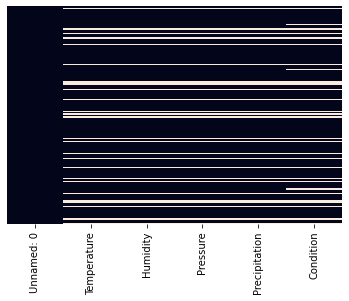

In [57]:
ax=sns.heatmap(weatherdata.isnull(), yticklabels=False, cbar=False)


Histograms

C:\Users\marci\AppData\Local\Temp\ipykernel_27864\2162525275.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


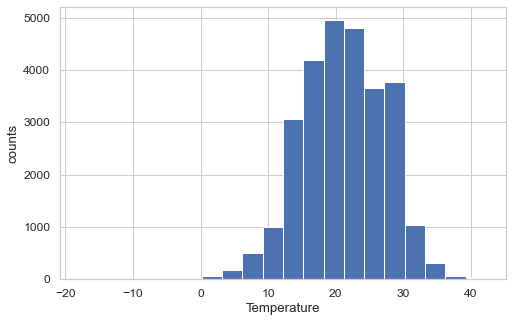

In [61]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    weatherdata['Temperature'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Temperature', ylabel='counts');

C:\Users\marci\AppData\Local\Temp\ipykernel_27864\3951612266.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


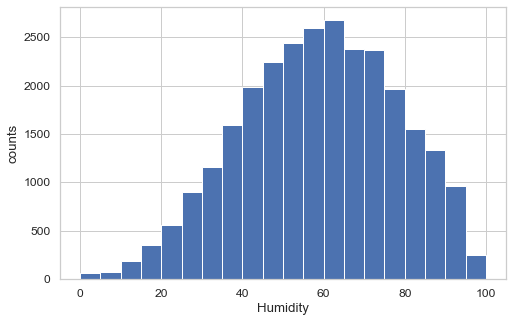

In [62]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    weatherdata['Humidity'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Humidity', ylabel='counts');

C:\Users\marci\AppData\Local\Temp\ipykernel_27864\620175890.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


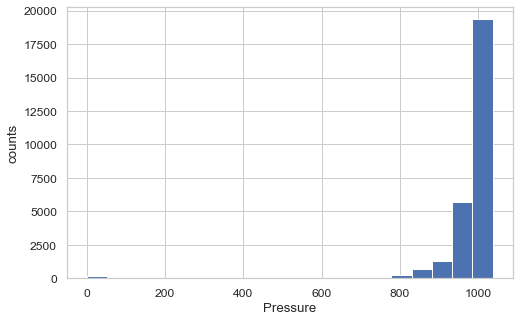

In [63]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    weatherdata['Pressure'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Pressure', ylabel='counts');

C:\Users\marci\AppData\Local\Temp\ipykernel_27864\1964909883.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


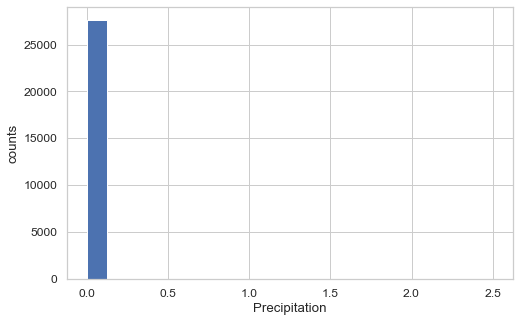

In [64]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    weatherdata['Precipitation'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Precipitation', ylabel='counts');

<AxesSubplot: xlabel='Humidity', ylabel='Temperature'>

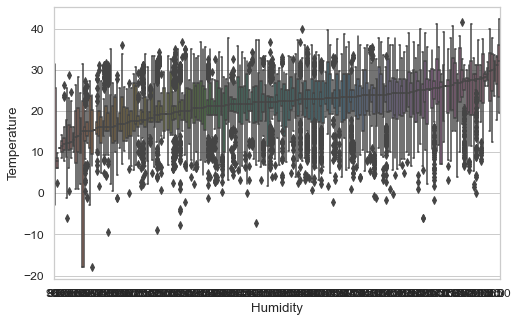

In [77]:
sorted_nb = weatherdata.groupby(['Humidity'])['Temperature'].median().sort_values()
sns.boxplot(x=weatherdata['Humidity'], y=weatherdata['Temperature'], order=list(sorted_nb.index))

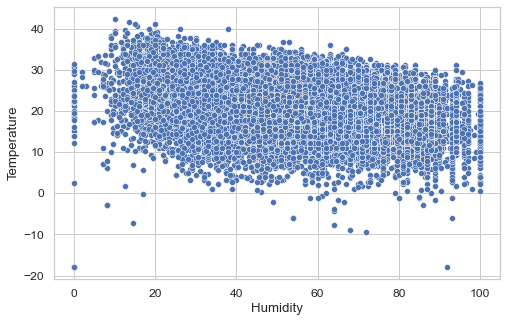

In [78]:
sns.scatterplot(x=weatherdata['Humidity'], y=weatherdata['Temperature']);

Conditions -> ints

In [76]:
Counter(Condition)

Counter({'': 6029,
         'Fair': 14842,
         'Mostly Cloudy': 6247,
         'Cloudy': 2207,
         'Partly Cloudy': 2569,
         'N/A': 337,
         'Mostly Cloudy / Windy': 125,
         'Showers in the Vicinity': 86,
         'Light Rain Shower / Windy': 11,
         'Rain Shower': 11,
         'Light Rain': 284,
         'Light Rain / Windy': 7,
         'Light Rain Shower': 147,
         'Cloudy / Windy': 63,
         'Fair / Windy': 358,
         'Haze': 22,
         'Blowing Dust / Windy': 2,
         'Mist': 13,
         'Partly Cloudy / Windy': 63,
         'Fog': 38,
         'T-Storm': 11,
         'Smoke': 9,
         'Thunder': 14,
         'Light Drizzle': 10,
         'Rain': 17,
         'Light Rain with Thunder': 10,
         'Light Snow': 5,
         'Light Drizzle / Windy': 1,
         'Sand': 1,
         'Heavy T-Storm': 10,
         'Thunder in the Vicinity': 6,
         'T-Storm / Windy': 1,
         'Drizzle': 2,
         'Heavy Rain Shower': 1,
     

C:\Users\marci\AppData\Local\Temp\ipykernel_27864\372221311.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


ValueError: could not convert string to float: 'Fair'

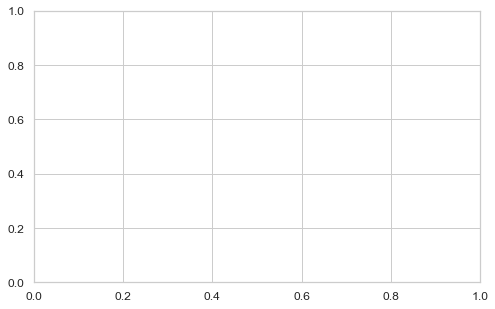

In [65]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    weatherdata['Condition'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Condition', ylabel='counts');

Analiza